In [1]:
from functions_for_all_nutrients import *
from vitamin_a_and_zinc_functions import *
from low_ses_functions import *

In [2]:
# Get absolute path of repo based on relative directory structure,
# so it should work for all users
import os.path
vivarium_research_lsff_path = os.path.abspath("..")
vivarium_research_lsff_path

'/ihme/homes/alibow/notebooks/vivarium_research_lsff'

In [3]:
username = !whoami
username

['alibow']

In [4]:
# Make shared directories in which to store GBD data so we don't have to keep calling `get_draws`

# Nathaniel has saved some .hdf files in this directory:
# You can change it if you save GBD data in a different directory.
read_share_dir = f'/share/scratch/users/ndbs/vivarium_lsff/gbd_data'

# GBD data will be stored here in an .hdf file if it doesn't exist in the directory above:
# You can change this directory name if you want, and you may need to create it before running code below.
#write_share_dir = f'/share/scratch/users/{username[0]}/vivarium_lsff/gbd_data'

In [5]:
index_cols=['location_id','sex_id','age_group_id']
age_group_ids = [2,3,4,5]
sex_ids = [1,2]
coverage_levels = [0.2,0.5,0.8]
years = [2021,2022,2023,2024,2025]

In [6]:
coverage_data_dir = vivarium_research_lsff_path + '/multiplication_models/low_ses_coverage.csv'
# # Old version that may not work for all users:
# coverage_data_dir = f'/ihme/homes/{username[0]}/notebooks/' \
#     'vivarium_research_lsff/data_prep/outputs/lsff_input_coverage_data.csv'

In [7]:
location_ids = [214]
location_ids

[214]

In [8]:
vitamin_a_burden_multiplier = 1.2
zinc_burden_multiplier = 1.2

In [9]:
cause_ids = [341, #measles
            302] #diarrheal diseases]

In [10]:
burden_multipliers = pd.DataFrame()
burden_multipliers['cause_id'] = cause_ids
burden_multipliers['multiplier'] = [1.48,1.45]
burden_multipliers

,cause_id,multiplier
0,341,1.48
1,302,1.45


# VITAMIN A

In [11]:
# vitamin A specific -- these should be replaced for other models
rei_id = 96
nutrient = 'vitamin a'
vehicles = ['oil']
effective_fractions = [0, 0, (365 - (365 * 0.5)) / (365 - 28), 1]

In [12]:
# define no fortification relative risk distribution
# vitamin a specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 2.22
q_975 = 5.26

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)b
rr_distribution = lognorm(s=sigma, scale=median)

In [13]:
vitamin_a_baseline_coverage, vitamin_a_counterfactual_coverage = get_baseline_and_counterfactual_coverage(coverage_data_dir,
                                             location_ids,
                                             nutrient,
                                             vehicles,
                                             years,
                                             coverage_levels, 'U5')
vitamin_a_counterfactual_coverage.head()

,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,location_id,vehicle,year
0,0.2,0.035534,0.013708,0.065921,0.044281,0.038209,0.073958,0.043379,0.050594,0.027348,...,0.077791,0.044660,0.049126,0.030397,0.038752,0.038738,0.063118,214,oil,2021
1,0.5,0.035534,0.013708,0.065921,0.044281,0.038209,0.073958,0.043379,0.050594,0.027348,...,0.077791,0.044660,0.049126,0.030397,0.038752,0.038738,0.063118,214,oil,2021
2,0.8,0.035534,0.013708,0.065921,0.044281,0.038209,0.073958,0.043379,0.050594,0.027348,...,0.077791,0.044660,0.049126,0.030397,0.038752,0.038738,0.063118,214,oil,2021
3,0.2,0.061845,0.034886,0.098764,0.072489,0.065103,0.108515,0.071392,0.080159,0.051847,...,0.113165,0.072950,0.078376,0.055578,0.065765,0.065748,0.095362,214,oil,2022
4,0.5,0.101312,0.066653,0.148028,0.114801,0.105444,0.160351,0.113413,0.124507,0.088596,...,0.166226,0.115385,0.122251,0.093349,0.106284,0.106262,0.143729,214,oil,2022


In [14]:
vitamin_a_baseline_effective_coverage = get_effective_vitamin_a_coverage(vitamin_a_baseline_coverage.set_index(['location_id','year','vehicle']), 
                                                               sex_ids,
                                                               age_group_ids,
                                                               effective_fractions,
                                                               years)
vitamin_a_counterfactual_effective_coverage = get_effective_vitamin_a_coverage(vitamin_a_counterfactual_coverage.set_index(['location_id','year','vehicle','coverage_level']), 
                                                               sex_ids,
                                                               age_group_ids,
                                                               effective_fractions,
                                                               years)

In [15]:
vitamin_a_rr_deficiency_nofort = generate_rr_deficiency_nofort_draws(mu, sigma, location_ids)
vitamin_a_rr_deficiency_nofort.mean(axis=1)

location_id
214    2.396239
dtype: float64

In [16]:
vitamin_a_exposure = pull_exposure(rei_id, sex_ids, age_group_ids, location_ids)
adjusted_exposure = adjust_exposure(vitamin_a_exposure, 'cat1', vitamin_a_burden_multiplier, ['location_id','age_group_id','sex_id'])
adjusted_exposure

draw_0    draw_1    draw_2    draw_3  \
location_id age_group_id sex_id                                           
214         2            1       0.041337  0.054878  0.043492  0.054796   
                         2       0.074500  0.034549  0.057805  0.045148   
            3            1       0.021211  0.065456  0.032366  0.080719   
                         2       0.035141  0.036714  0.054909  0.053740   
            4            1       0.106749  0.162090  0.080085  0.087327   
                         2       0.063649  0.103072  0.124763  0.064936   
            5            1       0.100888  0.177028  0.123740  0.118858   
                         2       0.066056  0.087989  0.106491  0.089059   

                                   draw_4    draw_5    draw_6    draw_7  \
location_id age_group_id sex_id                                           
214         2            1       0.040653  0.029172  0.047965  0.054406   
                         2       0.031335  0.118829  0.056158  0.046044   
            3            1       0.037637  0.078433  0.053894  0.017675   
                         2       0.071749  0.058971  0.030905  0.062069   
            4            1       0.036975  0.053873  0.170691  0.071726   
                         2       0.083321  0.116439  0.148376  0.074385   
            5            1       0.184192  0.055781  0.081918  0.109870   
                         2       0.065170  0.089150  0.153069  0.090258   

                                   draw_8    draw_9  ...  draw_990  draw_991  \
location_id age_group_id sex_id                      ...                       
214         2            1       0.024673  0.022496  ...  0.042392  0.040160   
                         2       0.091950  0.059878  ...  0.046283  0.062595   
            3            1       0.049996  0.080890  ...  0.028081  0.031984   
                         2       0.038101  0.028887  ...  0.045414  0.041927   
            4            1       0.072427  0.093617  ...  0.162391  0.076172   
                         2       0.148095  0.098101  ...  0.129940  0.105926   
            5            1       0.064507  0.158564  ...  0.064918  0.082671   
                         2       0.124853  0.076992  ...  0.062743  0.098480   

                                 draw_992  draw_993  draw_994  draw_995  \
location_id age_group_id sex_id                                           
214         2            1       0.028628  0.037723  0.025587  0.039582   
                         2       0.092164  0.044772  0.041250  0.041077   
            3            1       0.023330  0.015817  0.051901  0.023821   
                         2       0.024665  0.099064  0.097501  0.031229   
            4            1       0.071458  0.090664  0.136978  0.093424   
                         2       0.109082  0.053517  0.051749  0.152466   
            5            1       0.136653  0.034813  0.135445  0.068582   
                         2       0.070538  0.058275  0.120146  0.084013   

                                 draw_996  draw_997  draw_998  draw_999  
location_id age_group_id sex_id                                          
214         2            1       0.053596  0.023948  0.038784  0.034227  
                         2       0.040770  0.057874  0.102943  0.046809  
            3            1       0.034486  0.039969  0.018076  0.061359  
                         2       0.066888  0.051490  0.064622  0.047263  
            4            1       0.093052  0.147065  0.094482  0.104556  
                         2       0.066145  0.164329  0.036902  0.063579  
            5            1       0.097931  0.085172  0.182552  0.128083  
                         2       0.051643  0.083009  0.080231  0.059760  

[8 rows x 1000 columns]

In [17]:
dalys = pull_affected_dalys([341, 302], age_group_ids, sex_ids, location_ids)
dalys.head()

draw_0    draw_1   draw_10  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       1.518456  1.894415  1.554260   
                                341       0.000000  0.000000  0.000000   
            3            1      302       1.272435  1.117804  1.191778   
                                341       0.000000  0.000000  0.000000   
            4            1      302       1.012430  1.023720  0.862547   

                                          draw_100  draw_101  draw_102  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       1.957631  1.324234  1.429139   
                                341       0.000000  0.000000  0.000000   
            3            1      302       1.289628  1.049845  1.164874   
                                341       0.000000  0.000000  0.000000   
            4            1      302       1.140468  0.926229  0.962359   

                                          draw_103  draw_104  draw_105  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       1.333285  1.645348  1.684839   
                                341       0.000000  0.000000  0.000000   
            3            1      302       1.022793  1.046470  1.161979   
                                341       0.000000  0.000000  0.000000   
            4            1      302       0.854526  1.039891  0.914526   

                                          draw_106  ...  draw_990  draw_991  \
location_id age_group_id sex_id cause_id            ...                       
214         2            1      302       1.452657  ...  1.285709  1.273367   
                                341       0.000000  ...  0.000000  0.000000   
            3            1      302       1.155849  ...  0.900254  0.914634   
                                341       0.000000  ...  0.000000  0.000000   
            4            1      302       0.967374  ...  0.784248  0.772256   

                                          draw_992  draw_993  draw_994  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       1.248230  1.063368  1.172038   
                                341       0.000000  0.000000  0.000000   
            3            1      302       0.827491  0.733594  0.779121   
                                341       0.000000  0.000000  0.000000   
            4            1      302       0.689726  0.704100  0.710988   

                                          draw_995  draw_996  draw_997  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       1.544769  1.178902  1.242579   
                                341       0.000000  0.000000  0.000000   
            3            1      302       0.973080  0.753855  0.878656   
                                341       0.000000  0.000000  0.000000   
            4            1      302       0.930139  0.725708  0.777875   

                                          draw_998  draw_999  
location_id age_group_id sex_id cause_id                      
214         2            1      302       1.388514  1.327161  
                                341       0.000000  0.000000  
            3            1      302       0.880893  0.926098  
                                341       0.000000  0.000000  
            4            1      302       0.735216  0.724663  

[5 rows x 1000 columns]

In [18]:
adjusted_dalys = adjust_dalys(dalys, burden_multipliers)
adjusted_dalys.head()

draw_0    draw_1   draw_10  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       2.201762  2.746902  2.253677   
                                341       0.000000  0.000000  0.000000   
                         2      302       1.801176  2.315151  2.024755   
                                341       0.000000  0.000000  0.000000   
            3            1      302       1.845031  1.620816  1.728078   

                                          draw_100  draw_101  draw_102  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       2.838566  1.920140  2.072251   
                                341       0.000000  0.000000  0.000000   
                         2      302       2.380746  1.674353  1.756716   
                                341       0.000000  0.000000  0.000000   
            3            1      302       1.869961  1.522276  1.689067   

                                          draw_103  draw_104  draw_105  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       1.933263  2.385755  2.443017   
                                341       0.000000  0.000000  0.000000   
                         2      302       1.664296  1.967103  1.985647   
                                341       0.000000  0.000000  0.000000   
            3            1      302       1.483049  1.517381  1.684869   

                                          draw_106  ...  draw_990  draw_991  \
location_id age_group_id sex_id cause_id            ...                       
214         2            1      302       2.106353  ...  1.864278  1.846382   
                                341       0.000000  ...  0.000000  0.000000   
                         2      302       1.764572  ...  1.507661  1.554867   
                                341       0.000000  ...  0.000000  0.000000   
            3            1      302       1.675981  ...  1.305368  1.326219   

                                          draw_992  draw_993  draw_994  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       1.809933  1.541884  1.699455   
                                341       0.000000  0.000000  0.000000   
                         2      302       1.528781  1.265774  1.591964   
                                341       0.000000  0.000000  0.000000   
            3            1      302       1.199862  1.063711  1.129726   

                                          draw_995  draw_996  draw_997  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       2.239916  1.709407  1.801739   
                                341       0.000000  0.000000  0.000000   
                         2      302       1.881503  1.437006  1.484472   
                                341       0.000000  0.000000  0.000000   
            3            1      302       1.410966  1.093090  1.274052   

                                          draw_998  draw_999  
location_id age_group_id sex_id cause_id                      
214         2            1      302       2.013345  1.924383  
                                341       0.000000  0.000000  
                         2      302       1.549714  1.460695  
                                341       0.000000  0.000000  
            3            1      302       1.277295  1.342842  

[5 rows x 1000 columns]

In [19]:
relative_risks = pull_relative_risks(rei_id, age_group_ids, sex_ids)
relative_risks.head()

draw_0    draw_1    draw_2    draw_3  \
age_group_id sex_id cause_id                                           
4            1      302       1.134069  1.190973  1.111553  1.106425   
                    341       1.374825  1.587672  1.296105  1.278606   
             2      302       1.134069  1.190973  1.111553  1.106425   
                    341       1.374825  1.587672  1.296105  1.278606   
5            1      302       1.134069  1.190973  1.111553  1.106425   

                                draw_4    draw_5    draw_6    draw_7  \
age_group_id sex_id cause_id                                           
4            1      302       1.184413  1.132672  1.128937  1.075392   
                    341       1.562096  1.369850  1.356611  1.176010   
             2      302       1.184413  1.132672  1.128937  1.075392   
                    341       1.562096  1.369850  1.356611  1.176010   
5            1      302       1.184413  1.132672  1.128937  1.075392   

                                draw_8    draw_9  ...  draw_990  draw_991  \
age_group_id sex_id cause_id                      ...                       
4            1      302       0.971337  1.103949  ...  1.063016  1.145563   
                    341       0.871902  1.270209  ...  1.136661  1.416196   
             2      302       0.971337  1.103949  ...  1.063016  1.145563   
                    341       0.871902  1.270209  ...  1.136661  1.416196   
5            1      302       0.971337  1.103949  ...  1.063016  1.145563   

                              draw_992  draw_993  draw_994  draw_995  \
age_group_id sex_id cause_id                                           
4            1      302       1.191602  1.234630  1.227467  1.092492   
                    341       1.590136  1.764933  1.734996  1.231843   
             2      302       1.191602  1.234630  1.227467  1.092492   
                    341       1.590136  1.764933  1.734996  1.231843   
5            1      302       1.191602  1.234630  1.227467  1.092492   

                              draw_996  draw_997  draw_998  draw_999  
age_group_id sex_id cause_id                                          
4            1      302       1.118446  1.156072  1.114273  1.075186  
                    341       1.319880  1.454733  1.305455  1.175347  
             2      302       1.118446  1.156072  1.114273  1.075186  
                    341       1.319880  1.454733  1.305455  1.175347  
5            1      302       1.118446  1.156072  1.114273  1.075186  

[5 rows x 1000 columns]

In [20]:
pafs = calculate_adjusted_paf(adjusted_exposure, relative_risks)
pafs.head()

draw_0    draw_1    draw_2  \
location_id age_group_id sex_id cause_id                                 
214         4            1      302.0     0.014110  0.030025  0.008855   
                                341.0     0.038473  0.086971  0.023164   
                         2      302.0     0.008461  0.019304  0.013727   
                                341.0     0.023301  0.057113  0.035627   
            5            1      302.0     0.013345  0.032702  0.013616   

                                            draw_3    draw_4    draw_5  \
location_id age_group_id sex_id cause_id                                 
214         4            1      302.0     0.009208  0.006772  0.007097   
                                341.0     0.023752  0.020360  0.019536   
                         2      302.0     0.006863  0.015133  0.015213   
                                341.0     0.017770  0.044739  0.041287   
            5            1      302.0     0.012491  0.032851  0.007346   

                                            draw_6    draw_7    draw_8  \
location_id age_group_id sex_id cause_id                                 
214         4            1      302.0     0.021534  0.005378 -0.002080   
                                341.0     0.057377  0.012467 -0.009365   
                         2      302.0     0.018772  0.005577 -0.004263   
                                341.0     0.050254  0.012923 -0.019338   
            5            1      302.0     0.010452  0.008215 -0.001852   

                                            draw_9  ...  draw_990  draw_991  \
location_id age_group_id sex_id cause_id            ...                       
214         4            1      302.0     0.009638  ...  0.010130  0.010966   
                                341.0     0.024672  ...  0.021711  0.030728   
                         2      302.0     0.010095  ...  0.008122  0.015185   
                                341.0     0.025823  ...  0.017448  0.042224   
            5            1      302.0     0.016215  ...  0.004074  0.011891   

                                          draw_992  draw_993  draw_994  \
location_id age_group_id sex_id cause_id                                 
214         4            1      302.0     0.013507  0.020829  0.030216   
                                341.0     0.040464  0.064854  0.091469   
                         2      302.0     0.020472  0.012401  0.011634   
                                341.0     0.060480  0.039327  0.036642   
            5            1      302.0     0.025515  0.008102  0.029888   

                                          draw_995  draw_996  draw_997  \
location_id age_group_id sex_id cause_id                                 
214         4            1      302.0     0.008567  0.010901  0.022438   
                                341.0     0.021201  0.028905  0.062684   
                         2      302.0     0.013906  0.007774  0.025006   
                                341.0     0.034141  0.020720  0.069530   
            5            1      302.0     0.006303  0.011467  0.013119   

                                          draw_998  draw_999  
location_id age_group_id sex_id cause_id                      
214         4            1      302.0     0.010681  0.007800  
                                341.0     0.028051  0.018003  
                         2      302.0     0.004199  0.004757  
                                341.0     0.011146  0.011025  
            5            1      302.0     0.020435  0.009538  

[5 rows x 1000 columns]

In [21]:
attributable_daly_rates = calculate_attributable_dalys(dalys, pafs)
attributable_daly_rates.head()

draw_0  draw_1  draw_10  draw_100  \
location_id age_group_id sex_id cause_id                                      
214         2            1      302          0.0     0.0      0.0       0.0   
                                341          0.0     0.0      0.0       0.0   
                         2      302          0.0     0.0      0.0       0.0   
                                341          0.0     0.0      0.0       0.0   
            3            1      302          0.0     0.0      0.0       0.0   

                                          draw_101  draw_102  draw_103  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302            0.0       0.0       0.0   
                                341            0.0       0.0       0.0   
                         2      302            0.0       0.0       0.0   
                                341            0.0       0.0       0.0   
            3            1      302            0.0       0.0       0.0   

                                          draw_104  draw_105  draw_106  ...  \
location_id age_group_id sex_id cause_id                                ...   
214         2            1      302            0.0       0.0       0.0  ...   
                                341            0.0       0.0       0.0  ...   
                         2      302            0.0       0.0       0.0  ...   
                                341            0.0       0.0       0.0  ...   
            3            1      302            0.0       0.0       0.0  ...   

                                          draw_990  draw_991  draw_992  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302            0.0       0.0       0.0   
                                341            0.0       0.0       0.0   
                         2      302            0.0       0.0       0.0   
                                341            0.0       0.0       0.0   
            3            1      302            0.0       0.0       0.0   

                                          draw_993  draw_994  draw_995  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302            0.0       0.0       0.0   
                                341            0.0       0.0       0.0   
                         2      302            0.0       0.0       0.0   
                                341            0.0       0.0       0.0   
            3            1      302            0.0       0.0       0.0   

                                          draw_996  draw_997  draw_998  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302            0.0       0.0       0.0   
                                341            0.0       0.0       0.0   
                         2      302            0.0       0.0       0.0   
                                341            0.0       0.0       0.0   
            3            1      302            0.0       0.0       0.0   

                                          draw_999  
location_id age_group_id sex_id cause_id            
214         2            1      302            0.0  
                                341            0.0  
                         2      302            0.0  
                                341            0.0  
            3            1      302            0.0  

[5 rows x 1000 columns]

In [22]:
vitamin_a_dalys = calculate_overall_attributable_daly_counts(attributable_daly_rates, age_group_ids, location_ids, sex_ids)
vitamin_a_dalys = add_in_adjusted_paf_of_one(vitamin_a_dalys, location_ids, sex_ids, age_group_ids, 389, vitamin_a_burden_multiplier)
vitamin_a_dalys

,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,,,,,,,,,,,,,,,,,,,,,
214,203674.846348,351987.190068,128632.219354,307019.184675,67434.620941,86114.019432,80808.645567,178408.590503,209750.172276,229339.489833,...,100768.431382,197957.27159,249043.862983,176983.856529,280535.657529,144270.245819,97448.51955,199036.592104,156367.189497,80297.380418


In [23]:
vitamin_a_paf_deficiency_nofort = calculate_paf_deficiency_nofort(
                                    vitamin_a_rr_deficiency_nofort, 
                                    vitamin_a_baseline_effective_coverage)
vitamin_a_paf_deficiency_nofort.head()

draws                                          draw_0    draw_1   draw_10  \
location_id sex_id age_group_id year vehicle                                
214         1      2            2021 oil      0.78595  0.447022  0.406811   
                                2022 oil      0.78595  0.447022  0.406811   
                                2023 oil      0.78595  0.447022  0.406811   
                                2024 oil      0.78595  0.447022  0.406811   
                                2025 oil      0.78595  0.447022  0.406811   

draws                                         draw_100  draw_101  draw_102  \
location_id sex_id age_group_id year vehicle                                 
214         1      2            2021 oil      0.340996  0.617978  0.620854   
                                2022 oil      0.340996  0.617978  0.620854   
                                2023 oil      0.340996  0.617978  0.620854   
                                2024 oil      0.340996  0.617978  0.620854   
                                2025 oil      0.340996  0.617978  0.620854   

draws                                         draw_103  draw_104  draw_105  \
location_id sex_id age_group_id year vehicle                                 
214         1      2            2021 oil      0.149863  0.636347  0.421241   
                                2022 oil      0.149863  0.636347  0.421241   
                                2023 oil      0.149863  0.636347  0.421241   
                                2024 oil      0.149863  0.636347  0.421241   
                                2025 oil      0.149863  0.636347  0.421241   

draws                                         draw_106  ...  draw_990  \
location_id sex_id age_group_id year vehicle            ...             
214         1      2            2021 oil      0.759597  ...  0.507946   
                                2022 oil      0.759597  ...  0.507946   
                                2023 oil      0.759597  ...  0.507946   
                                2024 oil      0.759597  ...  0.507946   
                                2025 oil      0.759597  ...  0.507946   

draws                                         draw_991  draw_992  draw_993  \
location_id sex_id age_group_id year vehicle                                 
214         1      2            2021 oil      0.455066  0.740104  0.785748   
                                2022 oil      0.455066  0.740104  0.785748   
                                2023 oil      0.455066  0.740104  0.785748   
                                2024 oil      0.455066  0.740104  0.785748   
                                2025 oil      0.455066  0.740104  0.785748   

draws                                         draw_994  draw_995  draw_996  \
location_id sex_id age_group_id year vehicle                                 
214         1      2            2021 oil      0.396677  0.557149   0.64751   
                                2022 oil      0.396677  0.557149   0.64751   
                                2023 oil      0.396677  0.557149   0.64751   
                                2024 oil      0.396677  0.557149   0.64751   
                                2025 oil      0.396677  0.557149   0.64751   

draws                                         draw_997  draw_998  draw_999  
location_id sex_id age_group_id year vehicle                                
214         1      2            2021 oil      0.441514  0.406003  0.393076  
                                2022 oil      0.441514  0.406003  0.393076  
                                2023 oil      0.441514  0.406003  0.393076  
                                2024 oil      0.441514  0.406003  0.393076  
                                2025 oil      0.441514  0.406003  0.393076  

[5 rows x 1000 columns]

In [24]:
vitamin_a_pif_deficiency_nofort = calculate_pif_deficiency_nofort(
                                    vitamin_a_paf_deficiency_nofort,
                                    vitamin_a_baseline_effective_coverage,
                                    vitamin_a_counterfactual_effective_coverage)
vitamin_a_pif_deficiency_nofort.head()

draws                                                        draw_0  draw_1  \
location_id sex_id age_group_id year vehicle coverage_level                   
214         1      2            2021 oil     0.2                0.0     0.0   
                                             0.5                0.0     0.0   
                                             0.8                0.0     0.0   
                                2022 oil     0.2                0.0     0.0   
                                             0.5                0.0     0.0   

draws                                                        draw_10  \
location_id sex_id age_group_id year vehicle coverage_level            
214         1      2            2021 oil     0.2                 0.0   
                                             0.5                 0.0   
                                             0.8                 0.0   
                                2022 oil     0.2                 0.0   
                                             0.5                 0.0   

draws                                                        draw_100  \
location_id sex_id age_group_id year vehicle coverage_level             
214         1      2            2021 oil     0.2                  0.0   
                                             0.5                  0.0   
                                             0.8                  0.0   
                                2022 oil     0.2                  0.0   
                                             0.5                  0.0   

draws                                                        draw_101  \
location_id sex_id age_group_id year vehicle coverage_level             
214         1      2            2021 oil     0.2                  0.0   
                                             0.5                  0.0   
                                             0.8                  0.0   
                                2022 oil     0.2                  0.0   
                                             0.5                  0.0   

draws                                                        draw_102  \
location_id sex_id age_group_id year vehicle coverage_level             
214         1      2            2021 oil     0.2                  0.0   
                                             0.5                  0.0   
                                             0.8                  0.0   
                                2022 oil     0.2                  0.0   
                                             0.5                  0.0   

draws                                                        draw_103  \
location_id sex_id age_group_id year vehicle coverage_level             
214         1      2            2021 oil     0.2                  0.0   
                                             0.5                  0.0   
                                             0.8                  0.0   
                                2022 oil     0.2                  0.0   
                                             0.5                  0.0   

draws                                                        draw_104  \
location_id sex_id age_group_id year vehicle coverage_level             
214         1      2            2021 oil     0.2                  0.0   
                                             0.5                  0.0   
                                             0.8                  0.0   
                                2022 oil     0.2                  0.0   
                                             0.5                  0.0   

draws                                                        draw_105  \
location_id sex_id age_group_id year vehicle coverage_level             
214         1      2            2021 oil     0.2                  0.0   
                                             0.5                  0.0   
                                             0.8                  0.0   
                

In [25]:
vitamin_a_overall_pifs, vitamin_a_daly_reduction_counts = calculate_final_pifs_and_daly_reductions(
                                                    vitamin_a_pif_deficiency_nofort,
                                                    vitamin_a_dalys,
                                                    coverage_levels, years)

In [26]:
vitamin_a_daly_reduction_rates = calculate_rates(vitamin_a_daly_reduction_counts, 
                                            location_ids, 
                                            age_group_ids, 
                                            sex_ids)

In [27]:
vitamin_a_overall_pifs['measure'] = 'pif'
vitamin_a_daly_reduction_counts['measure'] = 'counts_averted'
vitamin_a_daly_reduction_rates['measure'] = 'rates_averted'
vitamin_a_results = pd.concat([vitamin_a_overall_pifs.reset_index(),
                         vitamin_a_daly_reduction_counts.reset_index(),
                         vitamin_a_daly_reduction_rates.reset_index()],
                        ignore_index=True)
#vitamin_a_results.to_pickle('results_raw/vitamin_a.pkl')

In [28]:
# pull in overall national results
nat = pd.read_pickle(vivarium_research_lsff_path + '/multiplication_models/results_raw/vitamin_a.pkl')
nat = nat.loc[nat.location_id.isin(vitamin_a_results.reset_index().location_id.unique())]
nat.head()

draws,location_id,year,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,measure
255,214,2021,oil,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif
256,214,2021,oil,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif
257,214,2021,oil,0.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif
258,214,2022,oil,0.2,1.812192,1.077408,0.952045,0.747953,1.339859,1.418512,...,1.058315,1.832229,1.769559,0.907649,1.273358,1.494963,0.926580,1.106837,0.865102,pif
259,214,2022,oil,0.5,4.530481,2.693521,2.380112,1.869883,3.349647,3.546279,...,2.645788,4.580573,4.423898,2.269123,3.183394,3.737407,2.316449,2.767092,2.162754,pif


In [29]:
# location_comparisons
vitamin_a_results['subgroup'] = 'Vulnerable Population'
nat['subgroup'] = 'Total Population'
results = pd.concat([vitamin_a_results,nat], ignore_index=True)
results.head()

draws,location_id,year,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,measure,subgroup
0,214,2021,oil,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif,Vulnerable Population
1,214,2021,oil,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif,Vulnerable Population
2,214,2021,oil,0.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif,Vulnerable Population
3,214,2022,oil,0.2,3.808518,1.711402,2.458308,1.752133,3.049564,4.013634,...,2.961811,5.270082,2.048705,2.999910,2.981664,2.176191,1.998575,2.328008,pif,Vulnerable Population
4,214,2022,oil,0.5,9.521296,4.278506,6.145770,4.380331,7.623909,10.034086,...,7.404526,13.175206,5.121762,7.499775,7.454159,5.440479,4.996437,5.820021,pif,Vulnerable Population


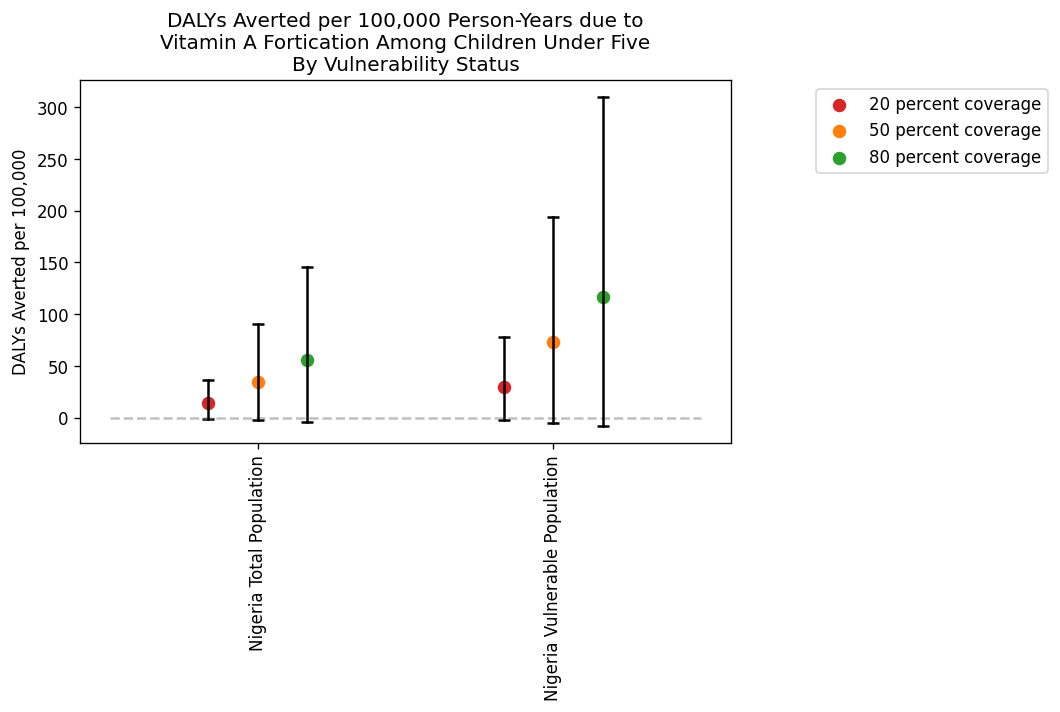

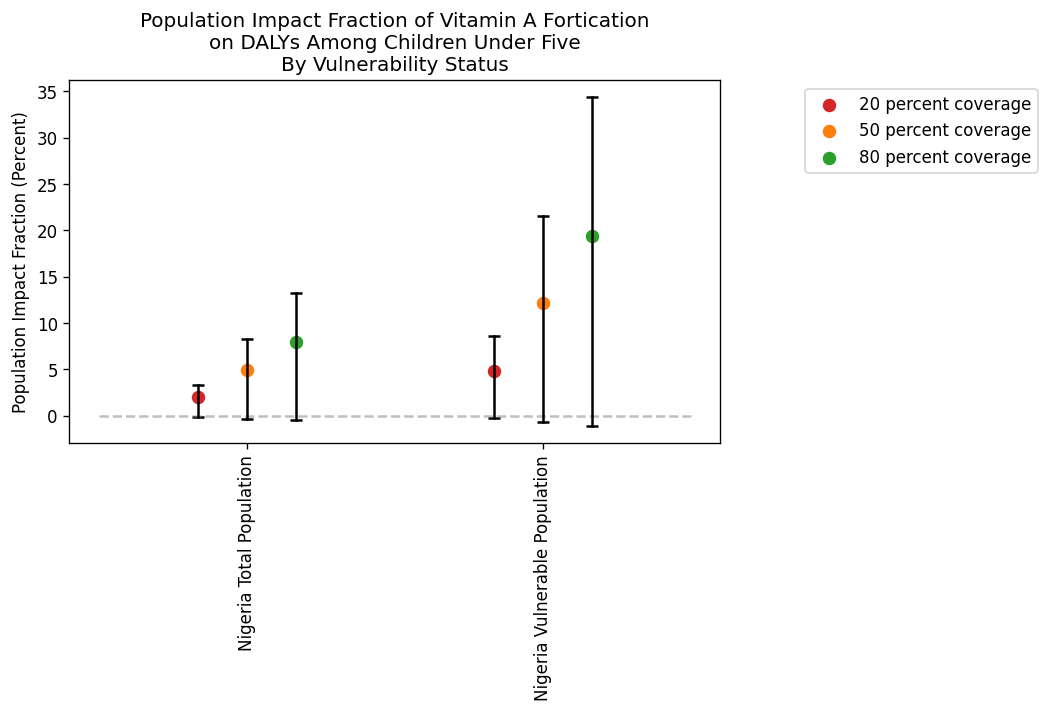

In [30]:
make_ses_comparison_dot_plots((results
                .sort_values(by='subgroup')
                .loc[results.measure=='rates_averted']
                .set_index([c for c in results.columns if 'draw' not in c]).sort_index()), 
               'Vitamin A', 'rates', coverage_levels, 'By Vulnerability Status', 
               'vitamin_a_u5_rates_averted_LOW_SES')
make_ses_comparison_dot_plots((results
                .sort_values(by='subgroup')
                .loc[results.measure=='pif']
                .set_index([c for c in results.columns if 'draw' not in c])), 
               'Vitamin A', 'pifs', coverage_levels, 'By Vulnerability Status', 
               'vitamin_a_u5_pif_LOW_SES')


# ZINC

In [31]:
# ZINC
rei_id = 97
nutrient = 'zinc'
vehicles = ['wheat flour', 'maize flour']
effective_fractions = [0,0,0,1]

In [32]:
# define no fortification relative risk distribution
# vitamin a specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 0.47
q_975 = 0.69

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)
rr_distribution = lognorm(s=sigma, scale=median)

In [59]:
zinc_baseline_coverage, zinc_counterfactual_coverage = zinc_baseline_coverage, zinc_counterfactual_coverage = get_baseline_and_counterfactual_coverage(coverage_data_dir,
                                             location_ids,
                                             'zinc',
                                             ['wheat flour','maize flour'],
                                             years,
                                             coverage_levels, 'U5')

In [61]:
zinc_rr_deficiency_nofort = (1 / generate_rr_deficiency_nofort_draws(mu, sigma, location_ids))
zinc_rr_deficiency_nofort.mean(axis=1)

location_id
214    2.178029
dtype: float64

In [62]:
zinc_baseline_effective_coverage = apply_age_related_effective_coverage_restrictions(
                                                                zinc_baseline_coverage.set_index([c for c in zinc_baseline_coverage.columns if 'draw' not in c]),
                                                                sex_ids,
                                                                age_group_ids,
                                                                effective_fractions)
zinc_counterfactual_effective_coverage = apply_age_related_effective_coverage_restrictions(
                                                                zinc_counterfactual_coverage.set_index([c for c in zinc_counterfactual_coverage.columns if 'draw' not in c]),
                                                                sex_ids,
                                                                age_group_ids,
                                                                effective_fractions)

In [63]:
zinc_exposure = pull_exposure(97, sex_ids, age_group_ids, location_ids)
zinc_exposure.head()

,rei_id,modelable_entity_id,location_id,year_id,age_group_id,sex_id,parameter,measure_id,metric_id,draw_0,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,97,2544.0,214,2019,5,1,cat1,18,3,0.035136,...,0.048633,0.084814,0.014329,0.026592,0.081539,0.096525,0.046741,0.021532,0.034779,0.075372
1,97,2544.0,214,2019,5,2,cat1,18,3,0.038128,...,0.048064,0.080456,0.014552,0.025763,0.078760,0.088153,0.038384,0.025220,0.033651,0.078609
2,97,NaN,214,2019,5,1,cat2,18,3,0.964864,...,0.951367,0.915186,0.985671,0.973408,0.918461,0.903475,0.953259,0.978468,0.965221,0.924628
3,97,NaN,214,2019,5,2,cat2,18,3,0.961872,...,0.951936,0.919544,0.985448,0.974237,0.921240,0.911847,0.961616,0.974780,0.966349,0.921391


In [64]:
zinc_rrs = pull_relative_risks(97, age_group_ids, sex_ids)
zinc_rrs.head()

draw_0    draw_1    draw_2   draw_3    draw_4  \
age_group_id sex_id cause_id                                                    
5            1      302       1.137545  1.171137  1.124065  1.12098  1.167298   
             2      302       1.137545  1.171137  1.124065  1.12098  1.167298   

                                draw_5    draw_6    draw_7    draw_8  \
age_group_id sex_id cause_id                                           
5            1      302       1.136712  1.134482  1.102183  1.037484   
             2      302       1.136712  1.134482  1.102183  1.037484   

                                draw_9  ...  draw_990  draw_991  draw_992  \
age_group_id sex_id cause_id            ...                                 
5            1      302       1.119488  ...  1.094625  1.144385  1.171505   
             2      302       1.119488  ...  1.094625  1.144385  1.171505   

                              draw_993  draw_994  draw_995  draw_996  \
age_group_id sex_id cause_id                                           
5            1      302       1.196469  1.192338  1.112567  1.128204   
             2      302       1.196469  1.192338  1.112567  1.128204   

                              draw_997  draw_998  draw_999  
age_group_id sex_id cause_id                                
5            1      302       1.150614    1.1257  1.102057  
             2      302       1.150614    1.1257  1.102057  

[2 rows x 1000 columns]

In [65]:
adjusted_zinc_exposure = adjust_exposure(zinc_exposure, 'cat1', zinc_burden_multiplier, ['location_id','age_group_id','sex_id'])
adjusted_zinc_exposure.head()

draw_0    draw_1    draw_2    draw_3  \
location_id age_group_id sex_id                                           
214         5            1       0.042164  0.001761  0.010408  0.056889   
                         2       0.045754  0.001357  0.011822  0.047038   

                                   draw_4    draw_5    draw_6    draw_7  \
location_id age_group_id sex_id                                           
214         5            1       0.109822  0.016149  0.052331  0.057536   
                         2       0.107148  0.016505  0.052595  0.056685   

                                   draw_8    draw_9  ...  draw_990  draw_991  \
location_id age_group_id sex_id                      ...                       
214         5            1       0.185233  0.029597  ...  0.058360  0.101777   
                         2       0.158637  0.027091  ...  0.057677  0.096547   

                                 draw_992  draw_993  draw_994  draw_995  \
location_id age_group_id sex_id                                           
214         5            1       0.017195  0.031910  0.097847  0.115830   
                         2       0.017462  0.030915  0.094511  0.105784   

                                 draw_996  draw_997  draw_998  draw_999  
location_id age_group_id sex_id                                          
214         5            1       0.056089  0.025838  0.041735  0.090446  
                         2       0.046061  0.030264  0.040381  0.094331  

[2 rows x 1000 columns]

In [66]:
zinc_affected_dalys = pull_affected_dalys(302, age_group_ids, sex_ids, location_ids)
zinc_affected_dalys.head()

draw_0    draw_1   draw_10  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       1.518456  1.894415  1.554260   
            3            1      302       1.272435  1.117804  1.191778   
            4            1      302       1.012430  1.023720  0.862547   
            5            1      302       0.222119  0.202963  0.227231   
            2            2      302       1.242190  1.596656  1.396383   

                                          draw_100  draw_101  draw_102  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       1.957631  1.324234  1.429139   
            3            1      302       1.289628  1.049845  1.164874   
            4            1      302       1.140468  0.926229  0.962359   
            5            1      302       0.251275  0.200569  0.215866   
            2            2      302       1.641894  1.154726  1.211528   

                                          draw_103  draw_104  draw_105  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       1.333285  1.645348  1.684839   
            3            1      302       1.022793  1.046470  1.161979   
            4            1      302       0.854526  1.039891  0.914526   
            5            1      302       0.230397  0.281014  0.203343   
            2            2      302       1.147790  1.356623  1.369411   

                                          draw_106  ...  draw_990  draw_991  \
location_id age_group_id sex_id cause_id            ...                       
214         2            1      302       1.452657  ...  1.285709  1.273367   
            3            1      302       1.155849  ...  0.900254  0.914634   
            4            1      302       0.967374  ...  0.784248  0.772256   
            5            1      302       0.218647  ...  0.194151  0.176793   
            2            2      302       1.216946  ...  1.039766  1.072322   

                                          draw_992  draw_993  draw_994  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       1.248230  1.063368  1.172038   
            3            1      302       0.827491  0.733594  0.779121   
            4            1      302       0.689726  0.704100  0.710988   
            5            1      302       0.170690  0.157174  0.169577   
            2            2      302       1.054332  0.872948  1.097906   

                                          draw_995  draw_996  draw_997  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       1.544769  1.178902  1.242579   
            3            1      302       0.973080  0.753855  0.878656   
            4            1      302       0.930139  0.725708  0.777875   
            5            1      302       0.222756  0.145097  0.172710   
            2            2      302       1.297588  0.991039  1.023774   

                                          draw_998  draw_999  
location_id age_group_id sex_id cause_id                      
214         2            1      302       1.388514  1.327161  
            3            1      302       0.880893  0.926098  
            4            1      302       0.735216  0.724663  
            5            1      302       0.170532  0.138519  
            2            2      302       1.068768  1.007376  

[5 rows x 1000 columns]

In [67]:
zinc_adjusted_dalys = adjust_dalys(zinc_affected_dalys, burden_multipliers)
zinc_adjusted_dalys.head()

draw_0    draw_1   draw_10  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       2.201762  2.746902  2.253677   
                         2      302       1.801176  2.315151  2.024755   
            3            1      302       1.845031  1.620816  1.728078   
                         2      302       1.339558  1.299229  1.313799   
            4            1      302       1.468024  1.484394  1.250693   

                                          draw_100  draw_101  draw_102  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       2.838566  1.920140  2.072251   
                         2      302       2.380746  1.674353  1.756716   
            3            1      302       1.869961  1.522276  1.689067   
                         2      302       1.474307  1.390618  1.315166   
            4            1      302       1.653679  1.343032  1.395421   

                                          draw_103  draw_104  draw_105  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       1.933263  2.385755  2.443017   
                         2      302       1.664296  1.967103  1.985647   
            3            1      302       1.483049  1.517381  1.684869   
                         2      302       1.366749  2.044404  1.490050   
            4            1      302       1.239062  1.507842  1.326063   

                                          draw_106  ...  draw_990  draw_991  \
location_id age_group_id sex_id cause_id            ...                       
214         2            1      302       2.106353  ...  1.864278  1.846382   
                         2      302       1.764572  ...  1.507661  1.554867   
            3            1      302       1.675981  ...  1.305368  1.326219   
                         2      302       1.523277  ...  1.170712  1.307789   
            4            1      302       1.402692  ...  1.137159  1.119771   

                                          draw_992  draw_993  draw_994  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       1.809933  1.541884  1.699455   
                         2      302       1.528781  1.265774  1.591964   
            3            1      302       1.199862  1.063711  1.129726   
                         2      302       1.284347  0.976857  1.026384   
            4            1      302       1.000103  1.020944  1.030932   

                                          draw_995  draw_996  draw_997  \
location_id age_group_id sex_id cause_id                                 
214         2            1      302       2.239916  1.709407  1.801739   
                         2      302       1.881503  1.437006  1.484472   
            3            1      302       1.410966  1.093090  1.274052   
                         2      302       1.234798  1.016891  1.097888   
            4            1      302       1.348701  1.052276  1.127919   

                                          draw_998  draw_999  
location_id age_group_id sex_id cause_id                      
214         2            1      302       2.013345  1.924383  
                         2      302       1.549714  1.460695  
            3            1      302       1.277295  1.342842  
                         2      302       0.934142  0.924335  
            4            1      302       1.066064  1.050761  

[5 rows x 1000 columns]

In [68]:
zinc_pafs = calculate_adjusted_paf(adjusted_zinc_exposure, zinc_rrs)
zinc_pafs.head()

draw_0    draw_1    draw_2  \
location_id age_group_id sex_id cause_id                                 
214         5            1      302       0.005766  0.000301  0.001290   
                         2      302       0.006254  0.000232  0.001465   

                                            draw_3    draw_4    draw_5  \
location_id age_group_id sex_id cause_id                                 
214         5            1      302       0.006835  0.018041  0.002203   
                         2      302       0.005659  0.017610  0.002251   

                                            draw_6    draw_7    draw_8  \
location_id age_group_id sex_id cause_id                                 
214         5            1      302       0.006988  0.005845  0.006895   
                         2      302       0.007023  0.005759  0.005911   

                                            draw_9  ...  draw_990  draw_991  \
location_id age_group_id sex_id cause_id            ...                       
214         5            1      302       0.003524  ...  0.005492  0.014482   
                         2      302       0.003227  ...  0.005428  0.013748   

                                          draw_992  draw_993  draw_994  \
location_id age_group_id sex_id cause_id                                 
214         5            1      302       0.002940  0.006230  0.018472   
                         2      302       0.002986  0.006037  0.017854   

                                          draw_995  draw_996  draw_997  \
location_id age_group_id sex_id cause_id                                 
214         5            1      302       0.012871  0.007140  0.003876   
                         2      302       0.011768  0.005871  0.004538   

                                          draw_998  draw_999  
location_id age_group_id sex_id cause_id                      
214         5            1      302       0.005219  0.009146  
                         2      302       0.005050  0.009535  

[2 rows x 1000 columns]

In [69]:
zinc_dalys = calculate_attributable_dalys(zinc_adjusted_dalys, zinc_pafs)
pop = get_population(sex_id=sex_ids,
                              age_group_id=age_group_ids,
                              location_id=location_ids,
                              year_id=2019,
                              gbd_round_id=6,
                             decomp_step='step4')
zinc_dalys = zinc_dalys.reset_index().merge(pop, on=['location_id','age_group_id','sex_id'])
for i in list(range(0,1000)):
    zinc_dalys[f'draw_{i}'] = zinc_dalys[f'draw_{i}'] * zinc_dalys[f'population']
zinc_dalys = zinc_dalys.groupby('location_id').sum()
zinc_dalys = zinc_dalys.drop(columns=[c for c in zinc_dalys.columns if 'draw' not in c])
zinc_dalys.head()

,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,,,,,,,,,,,,,,,,,,,,,
214,51300.1371,2065.556997,20559.742051,51612.461148,9640.084838,8462.588628,12737.508661,57109.155998,65017.797232,24860.551979,...,39678.070848,91256.861564,18409.050934,36466.181398,118937.619232,105547.704419,36584.847017,25675.689673,33571.078735,49939.469604


In [70]:
zinc_paf_deficiency_nofort = calculate_paf_deficiency_nofort(
                                    zinc_rr_deficiency_nofort, 
                                    zinc_baseline_effective_coverage)
zinc_paf_deficiency_nofort.head()

draws                                               draw_0    draw_1  \
location_id age_group_id sex_id year vehicle                           
214         2            1      2021 maize flour  0.345476  0.571001   
                                     wheat flour  0.345476  0.571001   
                                2022 maize flour  0.345476  0.571001   
                                     wheat flour  0.345476  0.571001   
                                2023 maize flour  0.345476  0.571001   

draws                                              draw_10  draw_100  \
location_id age_group_id sex_id year vehicle                           
214         2            1      2021 maize flour  0.584197  0.603221   
                                     wheat flour  0.584197  0.603221   
                                2022 maize flour  0.584197  0.603221   
                                     wheat flour  0.584197  0.603221   
                                2023 maize flour  0.584197  0.603221   

draws                                             draw_101  draw_102  \
location_id age_group_id sex_id year vehicle                           
214         2            1      2021 maize flour  0.494235   0.49253   
                                     wheat flour  0.494235   0.49253   
                                2022 maize flour  0.494235   0.49253   
                                     wheat flour  0.494235   0.49253   
                                2023 maize flour  0.494235   0.49253   

draws                                             draw_103  draw_104  \
location_id age_group_id sex_id year vehicle                           
214         2            1      2021 maize flour  0.645743  0.483019   
                                     wheat flour  0.645743  0.483019   
                                2022 maize flour  0.645743  0.483019   
                                     wheat flour  0.645743  0.483019   
                                2023 maize flour  0.645743  0.483019   

draws                                             draw_105  draw_106  ...  \
location_id age_group_id sex_id year vehicle                          ...   
214         2            1      2021 maize flour  0.579614  0.378442  ...   
                                     wheat flour  0.579614  0.378442  ...   
                                2022 maize flour  0.579614  0.378442  ...   
                                     wheat flour  0.579614  0.378442  ...   
                                2023 maize flour  0.579614  0.378442  ...   

draws                                             draw_990  draw_991  \
location_id age_group_id sex_id year vehicle                           
214         2            1      2021 maize flour  0.548122  0.568194   
                                     wheat flour  0.548122  0.568194   
                                2022 maize flour  0.548122  0.568194   
                                     wheat flour  0.548122  0.568194   
                                2023 maize flour  0.548122  0.568194   

draws                                             draw_992  draw_993  \
location_id age_group_id sex_id year vehicle                           
214         2            1      2021 maize flour  0.399642   0.34575   
                                     wheat flour  0.399642   0.34575   
                                2022 maize flour  0.399642   0.34575   
                                     wheat flour  0.399642   0.34575   
                                2023 maize flour  0.399642   0.34575   

draws                                             draw_994  draw_995  \
location_id age_group_id sex_id year vehicle                           
214         2            1      2021 maize flour  0.587321  0.526427   
                                     wheat flour  0.587321  0.526427   
                                2022 maize flour  0.587321  0.526427   
                                     wheat flour  0.587321  0.526427  

In [71]:
zinc_pif_deficiency_nofort = calculate_pif_deficiency_nofort(
                                    zinc_paf_deficiency_nofort,
                                    zinc_baseline_effective_coverage,
                                    zinc_counterfactual_effective_coverage)
zinc_pif_deficiency_nofort.head()

draws                                                            draw_0  \
location_id age_group_id sex_id year vehicle     coverage_level           
214         2            1      2021 maize flour 0.2                0.0   
                                                 0.5                0.0   
                                                 0.8                0.0   
                                     wheat flour 0.2                0.0   
                                                 0.5                0.0   

draws                                                            draw_1  \
location_id age_group_id sex_id year vehicle     coverage_level           
214         2            1      2021 maize flour 0.2                0.0   
                                                 0.5                0.0   
                                                 0.8                0.0   
                                     wheat flour 0.2                0.0   
                                                 0.5                0.0   

draws                                                            draw_10  \
location_id age_group_id sex_id year vehicle     coverage_level            
214         2            1      2021 maize flour 0.2                 0.0   
                                                 0.5                 0.0   
                                                 0.8                 0.0   
                                     wheat flour 0.2                 0.0   
                                                 0.5                 0.0   

draws                                                            draw_100  \
location_id age_group_id sex_id year vehicle     coverage_level             
214         2            1      2021 maize flour 0.2                  0.0   
                                                 0.5                  0.0   
                                                 0.8                  0.0   
                                     wheat flour 0.2                  0.0   
                                                 0.5                  0.0   

draws                                                            draw_101  \
location_id age_group_id sex_id year vehicle     coverage_level             
214         2            1      2021 maize flour 0.2                  0.0   
                                                 0.5                  0.0   
                                                 0.8                  0.0   
                                     wheat flour 0.2                  0.0   
                                                 0.5                  0.0   

draws                                                            draw_102  \
location_id age_group_id sex_id year vehicle     coverage_level             
214         2            1      2021 maize flour 0.2                  0.0   
                                                 0.5                  0.0   
                                                 0.8                  0.0   
                                     wheat flour 0.2                  0.0   
                                                 0.5                  0.0   

draws                                                            draw_103  \
location_id age_group_id sex_id year vehicle     coverage_level             
214         2            1      2021 maize flour 0.2                  0.0   
                                                 0.5                  0.0   
                                                 0.8                  0.0   
                                     wheat flour 0.2                  0.0   
                                                 0.5                  0.0   

draws                                                            draw_104  \
location_id age_group_id sex_id year vehicle     coverage_level             
214         2            1      2021 maize flour 0.2                  0.0   
                        

In [72]:
zinc_overall_pifs, zinc_daly_reduction_counts = calculate_final_pifs_and_daly_reductions(
                                                    zinc_pif_deficiency_nofort,
                                                    zinc_dalys,
                                                    coverage_levels, years)

In [73]:
zinc_daly_reduction_rates = calculate_rates(zinc_daly_reduction_counts, 
                                            location_ids, 
                                            age_group_ids, 
                                            sex_ids)

In [74]:
zinc_overall_pifs['measure'] = 'pif'
zinc_daly_reduction_counts['measure'] = 'counts_averted'
zinc_daly_reduction_rates['measure'] = 'rates_averted'
zinc_results = pd.concat([zinc_overall_pifs.reset_index(),
                         zinc_daly_reduction_counts.reset_index(),
                         zinc_daly_reduction_rates.reset_index()],
                        ignore_index=True)
#zinc_results.to_pickle('results_raw/zinc.pkl')
zinc_results

draws,location_id,year,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,measure
0,214,2021,maize flour,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif
1,214,2021,maize flour,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif
2,214,2021,maize flour,0.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif
3,214,2021,wheat flour,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif
4,214,2021,wheat flour,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,214,2025,maize flour,0.5,2.226411,0.060389,2.742138,4.833337,0.641767,1.064377,...,6.810248,0.457259,3.381033,10.933639,9.533287,1.884667,2.008661,2.678453,6.430655,rates_averted
86,214,2025,maize flour,0.8,3.562257,0.096623,4.387421,7.733340,1.026828,1.703004,...,10.896396,0.731614,5.409653,17.493822,15.253260,3.015468,3.213858,4.285524,10.289048,rates_averted
87,214,2025,wheat flour,0.2,3.424489,0.192079,2.853034,6.447989,0.942602,1.032664,...,10.210247,1.230004,3.165788,14.496274,11.851798,3.252206,2.928790,3.907775,6.864461,rates_averted
88,214,2025,wheat flour,0.5,8.561221,0.480198,7.132586,16.119972,2.356504,2.581660,...,25.525618,3.075010,7.914471,36.240686,29.629495,8.130515,7.321975,9.769436,17.161153,rates_averted


In [92]:
# pull in overall national results
nat = pd.read_pickle(vivarium_research_lsff_path + '/multiplication_models/results_raw/zinc.pkl')
nat = nat.loc[nat.location_id.isin(vitamin_a_results.reset_index().location_id.unique())]
nat.head()

draws,location_id,year,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,measure
375,214,2021.0,maize flour,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif
376,214,2021.0,maize flour,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif
377,214,2021.0,maize flour,0.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif
378,214,2021.0,wheat flour,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif
379,214,2021.0,wheat flour,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif


In [93]:
# location_comparisons
zinc_results['subgroup'] = 'Bottom Wealth Qunitile'
nat['subgroup'] = 'Total Population'
results = pd.concat([zinc_results,nat], ignore_index=True)
results.head()

draws,location_id,year,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,measure,subgroup
0,214,2021.0,maize flour,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,Bottom Wealth Qunitile
1,214,2021.0,maize flour,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,Bottom Wealth Qunitile
2,214,2021.0,maize flour,0.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,Bottom Wealth Qunitile
3,214,2021.0,wheat flour,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,Bottom Wealth Qunitile
4,214,2021.0,wheat flour,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,Bottom Wealth Qunitile


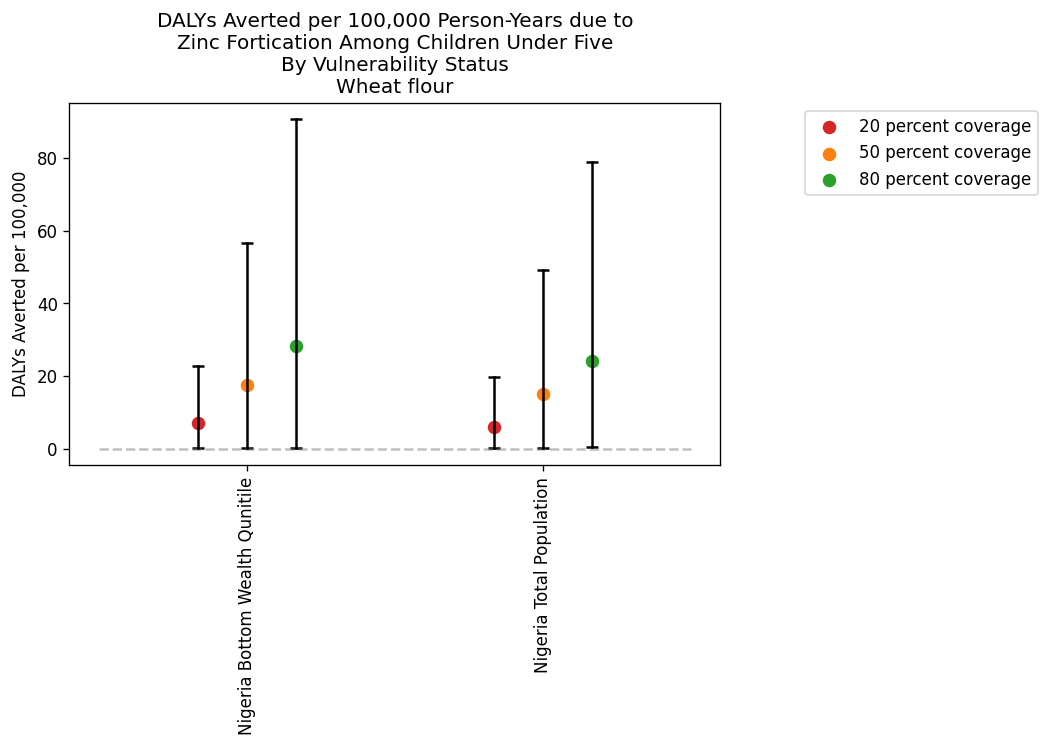

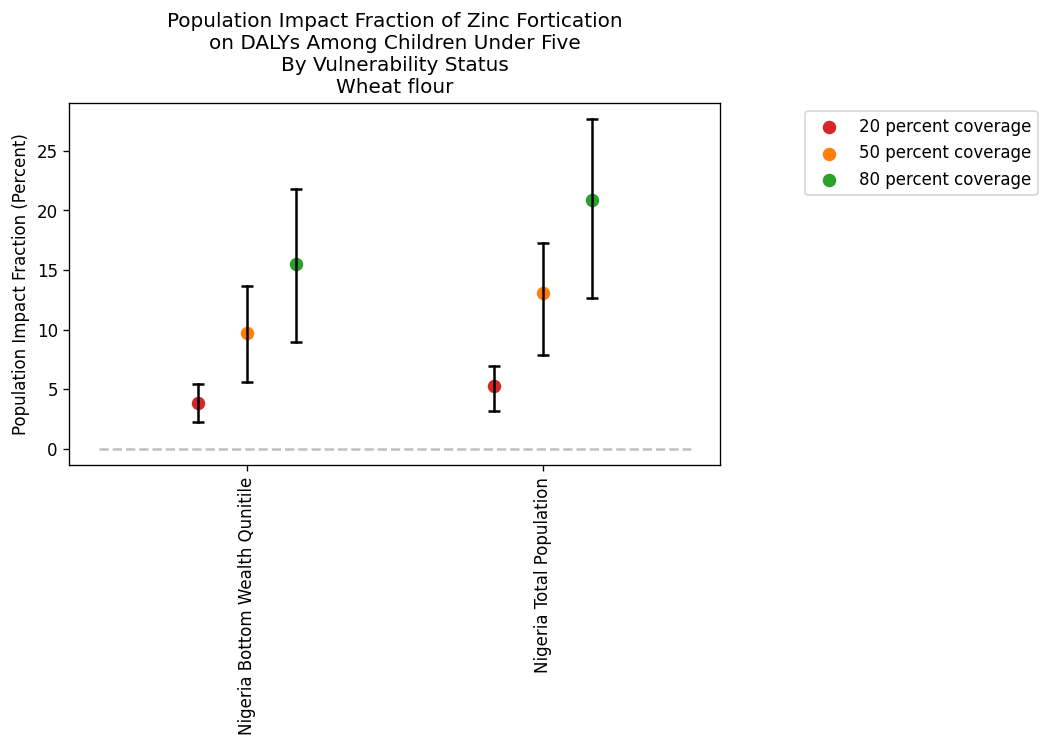

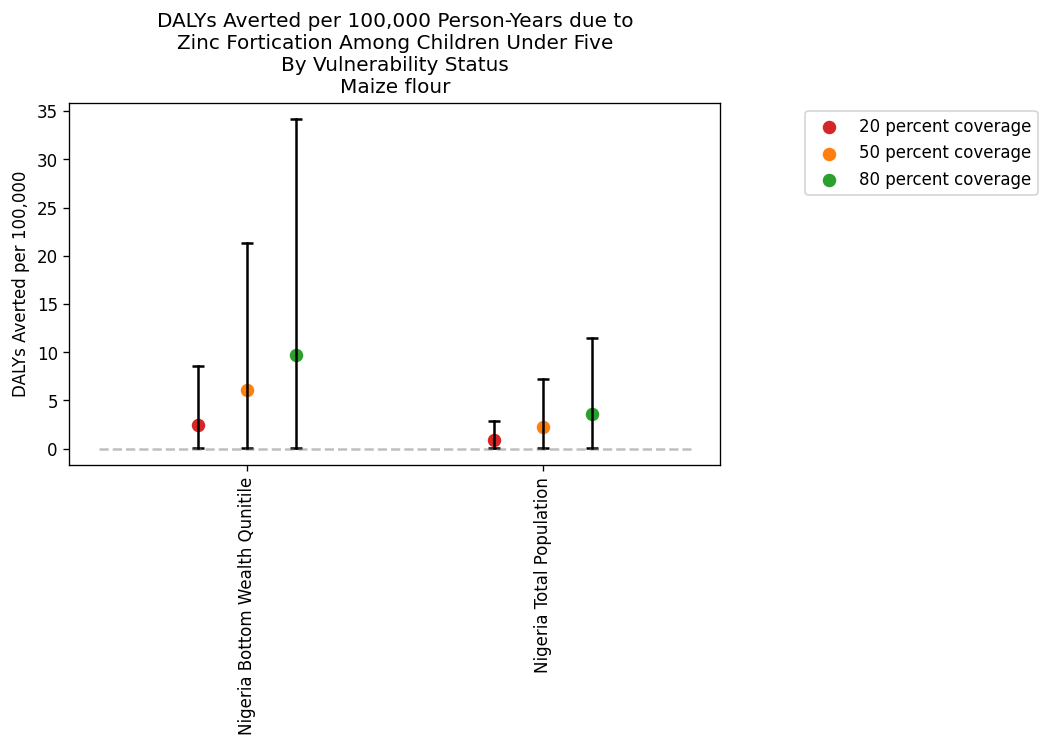

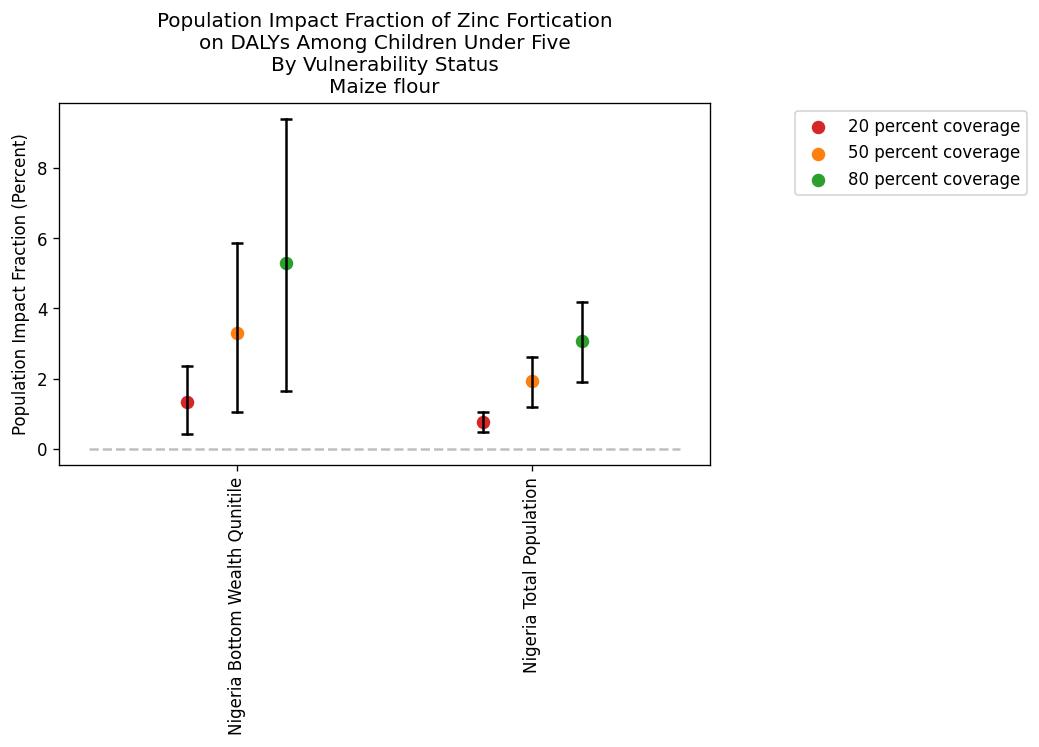

In [103]:
for vehicle in ['wheat flour','maize flour']:
    make_ses_comparison_dot_plots((results
                    .sort_values(by='subgroup')
                    .loc[results.measure=='rates_averted']
                                   .loc[results.vehicle == vehicle]
                    .set_index([c for c in results.columns if 'draw' not in c]).sort_index()), 
                   'Zinc', 'rates', coverage_levels, f'By Vulnerability Status\n{vehicle.capitalize()}', 
                   f'zinc_u5_rates_averted_LOW_SES_{vehicle}')
    make_ses_comparison_dot_plots((results
                    .sort_values(by='subgroup')
                                   .loc[results.vehicle==vehicle]
                    .loc[results.measure=='pif']
                    .set_index([c for c in results.columns if 'draw' not in c])), 
                   'Zinc', 'pifs', coverage_levels, f'By Vulnerability Status\n{vehicle.capitalize()}', 
                   f'zinc_u5_pif_LOW_SES_{vehicle}')

In [108]:
nat_cov = pd.read_pickle(vivarium_research_lsff_path + '/multiplication_models/results_raw/coverage_u5.pkl')
nat_cov = nat_cov.loc[nat_cov.location_id.isin(vitamin_a_results.reset_index().location_id.unique())]
nat_cov.head()

,coverage_level,location_id,year,nutrient,vehicle,mean,2.5%,97.5%
34,baseline,214,2021.0,vitamin a,oil,0.075293,0.058607,0.092009
35,baseline,214,2025.0,vitamin a,oil,0.075293,0.058607,0.092009
138,0.2,214,2021.0,vitamin a,oil,0.075293,0.058607,0.092009
139,0.5,214,2021.0,vitamin a,oil,0.075293,0.058607,0.092009
140,0.8,214,2021.0,vitamin a,oil,0.075293,0.058607,0.092009


In [109]:
nat_cov.vehicle.unique()

array(['oil', 'wheat flour', 'maize flour'], dtype=object)

In [110]:
vitamin_a_baseline_coverage['coverage_level'] = 'baseline'
vitamin_a_baseline_coverage['nutrient'] = 'vitamin a'
vitamin_a_counterfactual_coverage['nutrient'] = 'vitamin a'
zinc_baseline_coverage['coverage_level'] = 'baseline'
zinc_baseline_coverage['nutrient'] = 'zinc'
zinc_counterfactual_coverage['nutrient'] = 'zinc'

max_cov_ses = pd.DataFrame()
for nutrient in ['vitamin a','zinc']:
    if nutrient == 'vitamin a':
        vehicles = ['oil']
    else:
        vehicles = ['wheat flour', 'maize flour']
    for vehicle in vehicles:
        print(f'calculating {nutrient}/{vehicle}')
        cov_a, cov_b = generate_logical_coverage_draws(coverage_data_dir, location_ids, nutrient, vehicle, 'U5')
        cov_b['coverage_level'] = 'maximum'
        cov_b['nutrient'] = nutrient
        cov_b['vehicle'] = vehicle
        max_cov_ses = pd.concat([max_cov_ses, cov_b])

ses_cov = pd.concat([vitamin_a_baseline_coverage,
                    vitamin_a_counterfactual_coverage,
                    zinc_baseline_coverage,
                    zinc_counterfactual_coverage,
                    max_cov_ses.reset_index()], ignore_index=True, sort=True)
l = get_ids('location')
ses_cov = ses_cov.merge(l.filter(['location_name','location_id']), on='location_id')
ses_cov['location_id'] = ses_cov['location_id'] + 0.5
ses_cov = ses_cov.set_index([c for c in ses_cov.columns if 'draw' not in c])
ses_cov = ses_cov.apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1).filter(['mean','2.5%','97.5%']).reset_index()
ses_cov.head()

calculating vitamin a/oil
calculating zinc/wheat flour
calculating zinc/maize flour


,coverage_level,location_id,nutrient,vehicle,year,location_name,mean,2.5%,97.5%
0,baseline,214.5,vitamin a,oil,2021.0,Nigeria,0.054369,0.016867,0.090144
1,baseline,214.5,vitamin a,oil,2022.0,Nigeria,0.054369,0.016867,0.090144
2,baseline,214.5,vitamin a,oil,2023.0,Nigeria,0.054369,0.016867,0.090144
3,baseline,214.5,vitamin a,oil,2024.0,Nigeria,0.054369,0.016867,0.090144
4,baseline,214.5,vitamin a,oil,2025.0,Nigeria,0.054369,0.016867,0.090144


In [117]:
type(nat_cov.location_id.values[0])

numpy.int64

In [119]:
nat_cov.location_name

AttributeError: 'DataFrame' object has no attribute 'location_name'

In [120]:
l = get_ids('location')
nat_cov = nat_cov.merge(l.filter(['location_id','location_name']), on='location_id')
cov_prepped = pd.concat([ses_cov, nat_cov], ignore_index=True, sort=True)#.drop(columns='score')
cov_prepped['label'] = cov_prepped.location_name + np.where(cov_prepped.location_id - cov_prepped.location_id.astype(int) == 0,
                                                          ' Total Population', ' Bottom Wealth Quintile')
cov_prepped.head()

,2.5%,97.5%,coverage_level,location_id,location_name,mean,nutrient,vehicle,year,label
0,0.016867,0.090144,baseline,214.5,Nigeria,0.054369,vitamin a,oil,2021.0,Nigeria Bottom Wealth Quintile
1,0.016867,0.090144,baseline,214.5,Nigeria,0.054369,vitamin a,oil,2022.0,Nigeria Bottom Wealth Quintile
2,0.016867,0.090144,baseline,214.5,Nigeria,0.054369,vitamin a,oil,2023.0,Nigeria Bottom Wealth Quintile
3,0.016867,0.090144,baseline,214.5,Nigeria,0.054369,vitamin a,oil,2024.0,Nigeria Bottom Wealth Quintile
4,0.016867,0.090144,baseline,214.5,Nigeria,0.054369,vitamin a,oil,2025.0,Nigeria Bottom Wealth Quintile


In [121]:
def make_coverage_bar_charts(data, location_ids, nutrient, vehicle):
    plt.figure(figsize=(10, 4), dpi=120)
    
    data = (data
            .loc[data.vehicle==vehicle]
            .loc[data.nutrient.isin(['na',nutrient])]
            .loc[data.location_id.isin(location_ids)]
            .loc[data.year.isin([np.nan,2025])]
            .sort_values(by=['location_id'], ascending=True))
    data['mean'] = data['mean'] * 100
    data['2.5%'] = data['2.5%'] * 100
    data['97.5%'] = data['97.5%'] * 100
    base = data.loc[data.coverage_level=='baseline']
    alt_20 = data.loc[data.coverage_level==0.2]
    alt_50 = data.loc[data.coverage_level==0.5]
    alt_80 = data.loc[data.coverage_level==0.8]
    barWidth = 0.20
    a = np.arange(len(base))
    b = [x + barWidth for x in a]
    c = [x + barWidth for x in b]
    d = [x + barWidth for x in c]
    plt.bar(a, base['mean'], width=barWidth, yerr = [base['mean'] - base['2.5%'],base['97.5%'] - base['mean']], 
            label='Baseline Coverage')
    plt.bar(b, alt_20['mean'], width=barWidth, yerr = [alt_20['mean'] - alt_20['2.5%'],alt_20['97.5%'] - alt_20['mean']], 
            color='tab:red', label='20% Coverage')
    plt.bar(c, alt_50['mean'], width=barWidth, yerr = [alt_50['mean'] - alt_50['2.5%'],alt_50['97.5%'] - alt_50['mean']], 
            color='tab:orange', label='50% Coverage')
    plt.bar(d, alt_80['mean'], width=barWidth, yerr = [alt_80['mean'] - alt_80['2.5%'],alt_80['97.5%'] - alt_80['mean']], 
            color='tab:green', label='80% Coverage')

    df = data.loc[data.coverage_level=='maximum']
    for i in list(range(0,len(df.location_id.unique()))):
        if i == 0:
            plt.hlines(df.loc[df.location_id==df.location_id.unique()[i]]['mean'], -0.1 + i, 0.7 + i, 
                   linestyle='dashed', color='black', label='Eating industrially produced vehicle')
        else: 
            plt.hlines(df.loc[df.location_id==df.location_id.unique()[i]]['mean'], -0.1 + i, 0.7 + i, 
                   linestyle='dashed', color='black')
        plt.fill_between([-0.1 + i, 0.7 + i], [df.loc[df.location_id==df.location_id.unique()[i]]['2.5%'].values[0]] * 2,
                        [df.loc[df.location_id==df.location_id.unique()[i]]['97.5%'].values[0]] * 2,
                        alpha=0.2, color='black')
    
    plt.legend(bbox_to_anchor=[1.45,1])
    plt.title(f'{nutrient.capitalize()} in {vehicle} fortification coverage')
    plt.ylabel('Percent of population')
    plt.xticks([r + barWidth * 1.5 for r in range(len(df))], base['label'].values)#, rotation=90)
    plt.savefig(f'results_plots/low_ses/coverage_{nutrient}_{vehicle}.png', bbox_inches='tight')

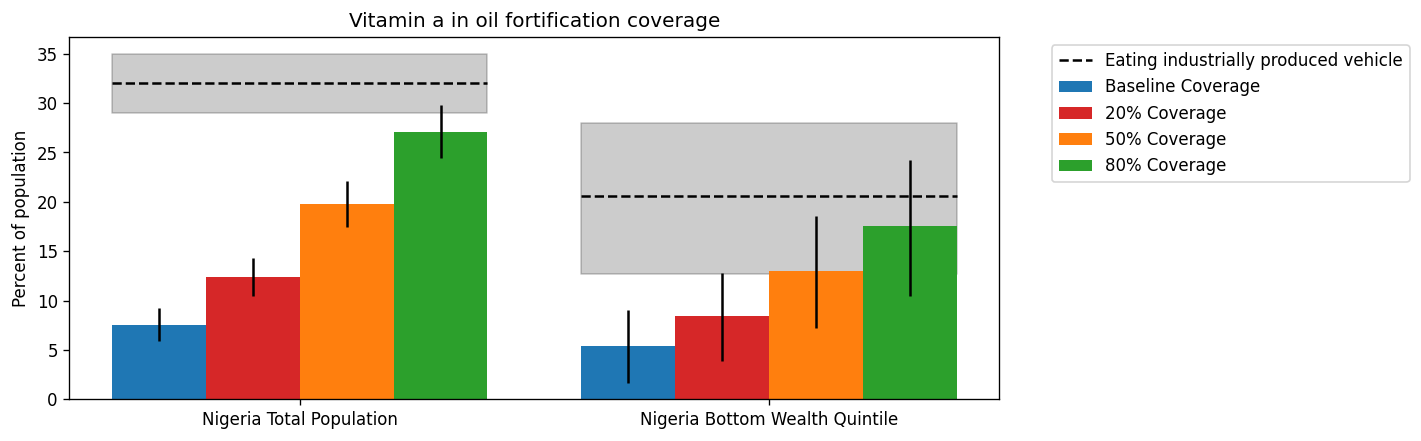

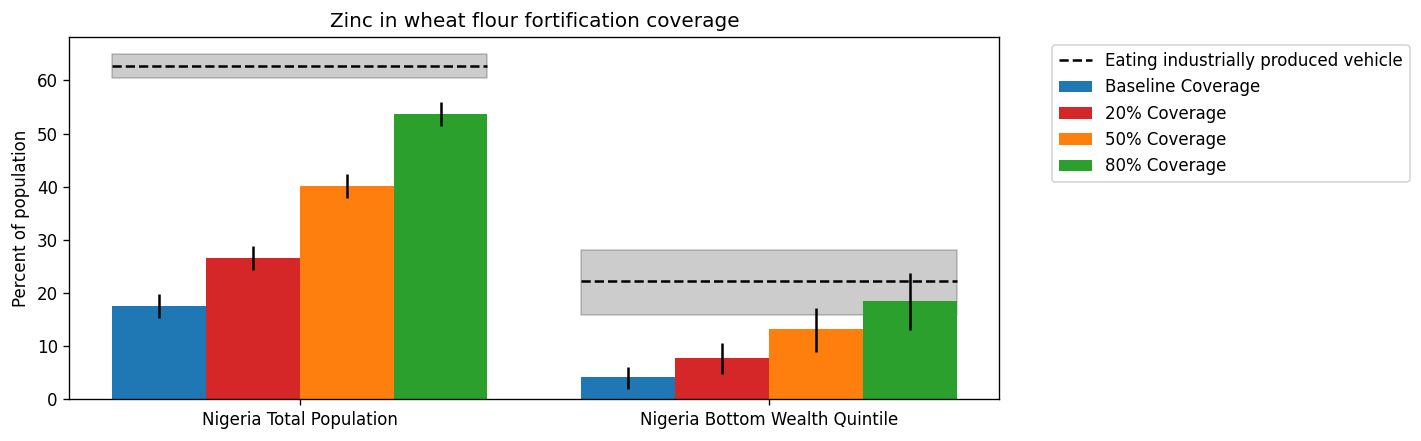

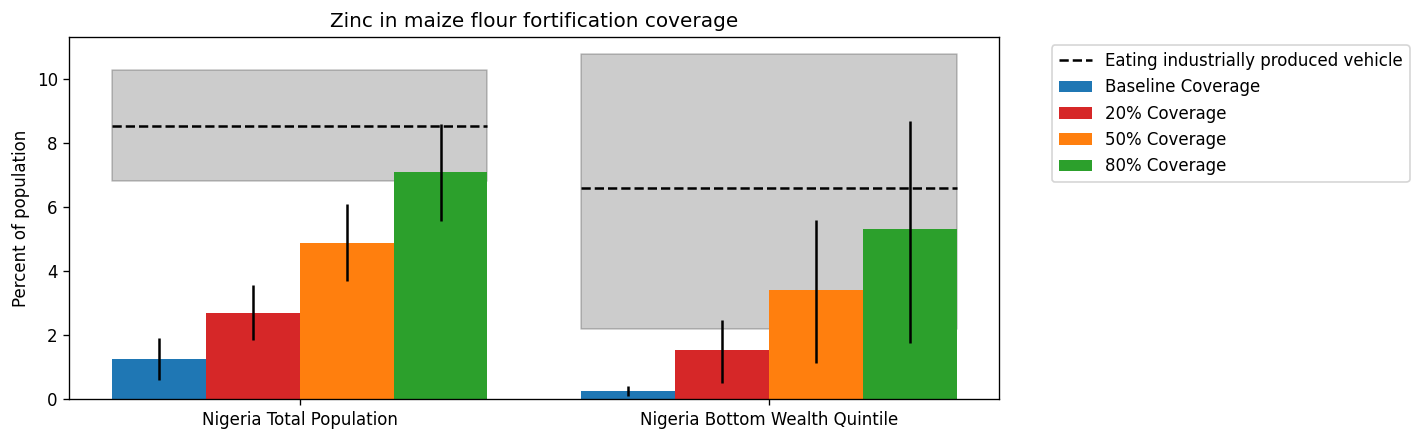

In [122]:
for nutrient in ['vitamin a','zinc']:
    if nutrient == 'vitamin a':
        vehicles = ['oil']
    else:
        vehicles = ['wheat flour', 'maize flour']
    for vehicle in vehicles:
        make_coverage_bar_charts(cov_prepped, [214,214.5], nutrient, vehicle)